# motivation

I spent hours daily driving on one of the busiest motorways in the Netherlands , when commuting was still a norm. When I first came across with the goods vehicle data on CBS website, it immediately attracted my attention: it could answer those not so important questions that I have always had, when stuck in a traffic jam after a long day of work, alongside the lorries.

- What are the types of common goods vehicle? How can we tell them apart using data?
- What is the lifespan of a goods vehicle?
- Why is there such high volume of goods vehicle on the motorways nowadays?


In [61]:
import cbsodata
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_palette("husl")

In [62]:
# Downloading table list from cbs portal
df = pd.DataFrame(cbsodata.get_data('84651ENG'))

In [63]:
df.head()

,ID,LorriesAndRoadTractors,YearsOfConstruction,Periods,TotalKilometresInTheNetherlands_1,KilometresByDutchVehicles_2,KilometresByForeignVehicles_3,TotalKilometresByDutchVehicles_4,KilometresInTheNetherlands_5,KilometresAbroad_6,TotalAverageAnnualKilometres_7,AverageAnnualKilometresInNetherlands_8,AverageAnnualKilometresAbroad_9,DutchGoodsVehiclesInUse_10
0,0,Lorries and road tractors,Total of all construction years,2001,6592.1,6014.7,577.5,9869.7,6014.7,3855.1,58913.0,35902.0,23011.0,167530.0
1,1,Lorries and road tractors,Total of all construction years,2002,6600.8,5999.6,601.1,9973.7,5999.6,3974.1,59846.0,36000.0,23846.0,166657.0
2,2,Lorries and road tractors,Total of all construction years,2003,6610.0,6025.4,584.6,10026.9,6025.4,4001.5,61150.0,36746.0,24403.0,163974.0
3,3,Lorries and road tractors,Total of all construction years,2004,6684.5,6060.0,624.5,10070.7,6060.0,4010.7,61637.0,37090.0,24547.0,163387.0
4,4,Lorries and road tractors,Total of all construction years,2005,6797.2,6128.7,668.5,10181.2,6128.7,4052.5,62792.0,37798.0,24994.0,162142.0


In [64]:
# Downloading metadata
metadata_data_properties = pd.DataFrame(cbsodata.get_meta('84651ENG', 'DataProperties'))
# metadata_data_properties[['Key','Title','Description']]

# pre-processing categorical data 

In [65]:
cat_col = df.columns[df.dtypes == 'object']
df[cat_col].describe()

,LorriesAndRoadTractors,YearsOfConstruction,Periods
count,1836,1836,1836
unique,6,17,18
top,To 10 000 kg,2010,2004
freq,306,108,102


## lorries and road tracoter

In [66]:
# Read metadata
pd.DataFrame(cbsodata.get_meta('84651ENG', 'LorriesAndRoadTractors'))

,Key,Title,Description,CategoryGroupID
0,A018938,Lorries and road tractors,Lorry\r\nRigid heavy goods road vehicle with a...,None
1,A018937,Road tractor,"Road motor vehicle, exclusively or primarily d...",None
2,A018936,Lorry (road tractor not included),Rigid heavy goods road vehicle with a gross ve...,None
3,A028272,To 10 000 kg,The total weight of the vehicle (or combinatio...,None
4,A028273,10 000 to 20 000 kg,The total weight of the vehicle (or combinatio...,None
5,A028274,20 000 kg or more,The total weight of the vehicle (or combinatio...,None


In [67]:
df_goupby_vechile_type = df.groupby(['LorriesAndRoadTractors']).sum()['DutchGoodsVehiclesInUse_10']

In [68]:
df_goupby_vechile_type

LorriesAndRoadTractors
10 000 to 20 000 kg                  1295550.0
20 000 kg or more                     987069.0
Lorries and road tractors            5914882.0
Lorry (road tractor not included)    2936908.0
Road tractor                         2977974.0
To 10 000 kg                          654290.0
Name: DutchGoodsVehiclesInUse_10, dtype: float64

Obviously 'Lorries and road tractors' is the summation of 'Road tractor' and 'Lorry (road tractor not included)'. to avoid double-counting the values, it is decided to drop the rows where the vehicle type is 'Lorries and road tractors'

'To 10 000 kg' and '10 t to 20 t', '20 t' are sub-cat of the tractor types. it is decided to drop those rows as well.

In [69]:
# Drop subgroups
df.drop(df[df['LorriesAndRoadTractors'] == 'Lorries and road tractors'].index, axis=0, inplace=True)
df.drop(df[df['LorriesAndRoadTractors'] == 'To 10 000 kg'].index, axis=0, inplace=True)
df.drop(df[df['LorriesAndRoadTractors'] == '10 000 to 20 000 kg'].index, axis=0, inplace=True)
df.drop(df[df['LorriesAndRoadTractors'] == '20 000 kg or more'].index, axis=0, inplace=True)

In [70]:
# Rename the columns
df['LorriesAndRoadTractors'].replace({'Lorry (road tractor not included)':"Lorry"}, inplace = True)

## Years Of Construction

In [71]:
def dimension_size(df, col):
    return len(df[col].unique())

In [72]:
len_Periods = dimension_size(df, 'Periods')
len_LorriesAndRoadTractors = dimension_size(df, "LorriesAndRoadTractors")

if len(df.loc[df["YearsOfConstruction"] == 'Total of all construction years']) == len_Periods* len_LorriesAndRoadTractors:
    print('Row total of all construction years present a summation of the other years')

Row total of all construction years present a summation of the other years


In [73]:
df = df.drop(df.loc[df["YearsOfConstruction"] == 'Total of all construction years'].index)

# Numerical data

In [74]:
if 'ID' in df.columns:
    df = df.drop(['ID'], axis=1)

In [75]:
df.nunique(axis=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, '0.1f')))

,TotalKilometresInTheNetherlands_1,KilometresByDutchVehicles_2,KilometresByForeignVehicles_3,TotalKilometresByDutchVehicles_4,KilometresInTheNetherlands_5,KilometresAbroad_6,TotalAverageAnnualKilometres_7,AverageAnnualKilometresInNetherlands_8,AverageAnnualKilometresAbroad_9,DutchGoodsVehiclesInUse_10
count,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0
mean,445.2,398.9,46.3,626.6,398.9,227.7,61416.4,40537.8,20878.6,10487.4
std,472.6,423.8,59.4,741.4,423.8,352.7,28600.6,14950.1,15962.4,11809.8
min,21.7,19.7,2.0,26.3,19.7,6.7,5368.0,4743.0,625.0,1742.0
25%,174.1,160.2,11.5,208.1,160.2,46.3,40891.5,29358.5,9374.8,4245.5
50%,277.1,242.9,19.6,355.5,242.9,88.0,59441.0,43855.5,15084.0,6278.0
75%,526.6,462.6,65.5,774.3,462.6,287.4,83278.8,51050.5,32021.5,10414.5
max,2611.0,2492.8,387.6,4481.4,2492.8,2401.1,122680.0,73155.0,73608.0,81535.0


## correlation

<AxesSubplot:>

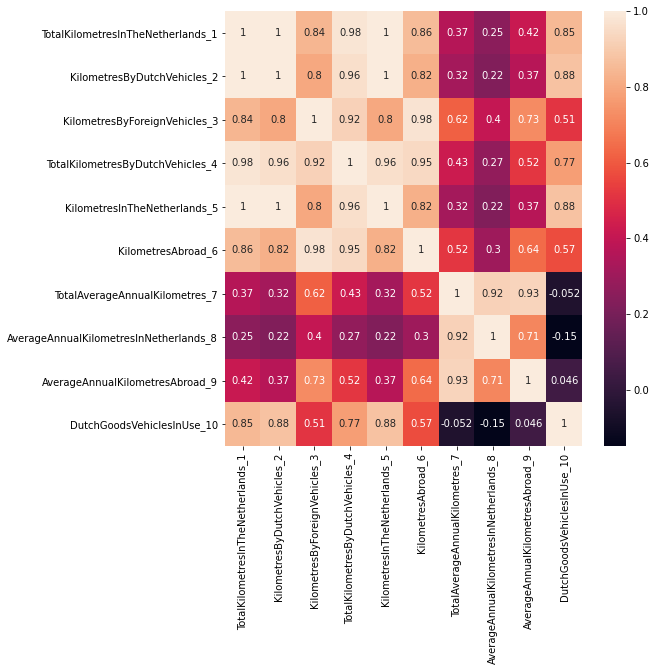

In [76]:
# establish the correlation matrix
corr = df.corr()
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True)

quite some information is highly correlated. therefore it is decided to keep only the most relavent columns

## drop the highly correlated columns

In [77]:
to_keep = ['LorriesAndRoadTractors', 
        'YearsOfConstruction', 
        'Periods',
        'KilometresByDutchVehicles_2',
        'KilometresByForeignVehicles_3',
        'KilometresInTheNetherlands_5',  
        'KilometresAbroad_6',
        'DutchGoodsVehiclesInUse_10'] 

In [78]:
df = df[to_keep].copy()

## drop NaN

We would like to see if there is any outlier, wrong data included in the dataset, and assign NAN with a reasonable value

In [79]:
# drop NaN columns
df.isna().sum()/df.shape[0]

LorriesAndRoadTractors           0.000000
YearsOfConstruction              0.000000
Periods                          0.000000
KilometresByDutchVehicles_2      0.510417
KilometresByForeignVehicles_3    0.510417
KilometresInTheNetherlands_5     0.510417
KilometresAbroad_6               0.510417
DutchGoodsVehiclesInUse_10       0.510417
dtype: float64

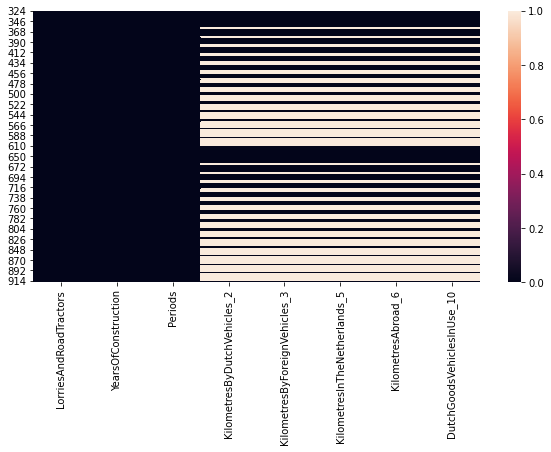

In [80]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(df.isnull())
plt.show()

Quite some data is missing. As seen from above NaN purely because the data is not avaiable for the correspoind (years of contruction, periods) combinataion

In [81]:
df.dropna(inplace=True)

# Lorries and tractor types

In [82]:
df_type =  df.groupby(['Periods',"LorriesAndRoadTractors"]).sum()
df_type.reset_index(inplace=True)  # flatten the dataframe

## variation of total number of registered vehicles over the years

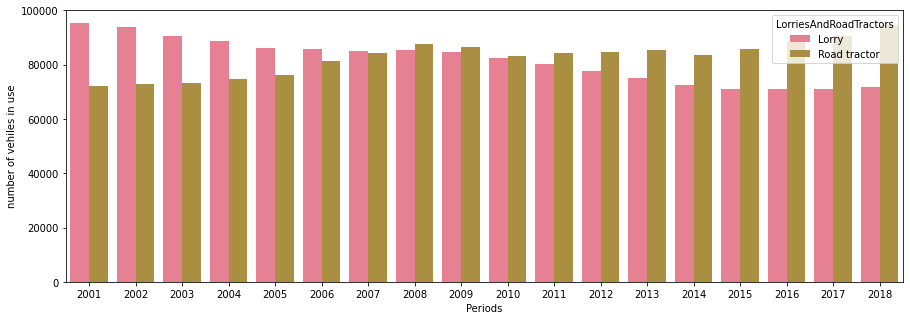

In [83]:
# Present the variation of total number of registered vehicles over the years
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x="Periods", y="DutchGoodsVehiclesInUse_10", 
             hue="LorriesAndRoadTractors",  data=df_type, ax = ax)

ax.set_ylabel ('number of vehiles in use')
fig.savefig('./image/number_of_vehiles_in_use.png', bbox_inches = 'tight',dpi=150)

## variation of total number of vehicles kilometres over the years

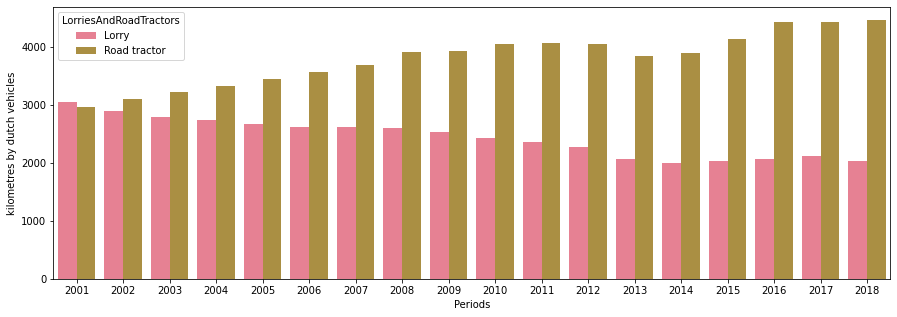

In [84]:
# Present the variation of total number of vehicles kilometres over the years
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x="Periods", y="KilometresByDutchVehicles_2", 
             hue="LorriesAndRoadTractors",  data=df_type)

ax.set_ylabel('kilometres by dutch vehicles')
fig.savefig('./image/kilometres_by_dutch_vehicles.png', bbox_inches = 'tight')

## annual average kilometer in NL and abroad

In [85]:
df_type['AverageAnnualKilometer'] = (df_type['KilometresInTheNetherlands_5'] + df_type['KilometresAbroad_6'])/df_type['DutchGoodsVehiclesInUse_10']

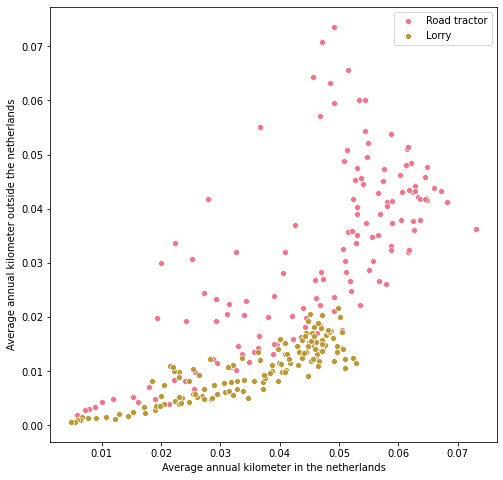

In [86]:
# add labels for x and y axis 
fig, ax = plt.subplots(figsize = (8, 8))

for lorries in df['LorriesAndRoadTractors'].unique():
    
    sns.scatterplot( x = df.loc[df['LorriesAndRoadTractors'] == lorries]['KilometresInTheNetherlands_5']/df.loc[df['LorriesAndRoadTractors'] == lorries]['DutchGoodsVehiclesInUse_10'], 
                y = df.loc[df['LorriesAndRoadTractors'] == lorries]['KilometresAbroad_6']/df.loc[df['LorriesAndRoadTractors'] == lorries]['DutchGoodsVehiclesInUse_10'], label = lorries)
    
ax.set_xlabel('Average annual kilometer in the netherlands')
ax.set_ylabel('Average annual kilometer outside the netherlands')
fig.savefig('./image/average_annual_kilometer_by_dutch_vehicles.png', bbox_inches = 'tight')

observations:

- lorries travel more frequently travel in the neterlands than abroad
- road trator more likely to be abroad than the rest. 

## Service life

1. Include one more column named [YearInService]
2. plot the varation normalized value 

In [87]:
# drop row with non-numerical values
df_years_in_service =  df.drop(df.loc[(df["YearsOfConstruction"] ==
                                      'Year of construction 1900 to 2000') | 
                                       (df["YearsOfConstruction"] ==
                                      'Year of construction 2000 to 2005')].index).copy()

In [88]:
df_years_in_service['YearsInService'] = df_years_in_service['Periods'].astype('int') - df_years_in_service['YearsOfConstruction'].astype('int') 

### Annual new construction 

determine the number of new construction for the period from 2001 to 2018

In [89]:
# yearly new construction 
df_yearly_new_construction = df_years_in_service[df_years_in_service['YearsInService'] == 0].copy()
df_yearly_new_construction['yearly_new_construction'] = df_yearly_new_construction['DutchGoodsVehiclesInUse_10']

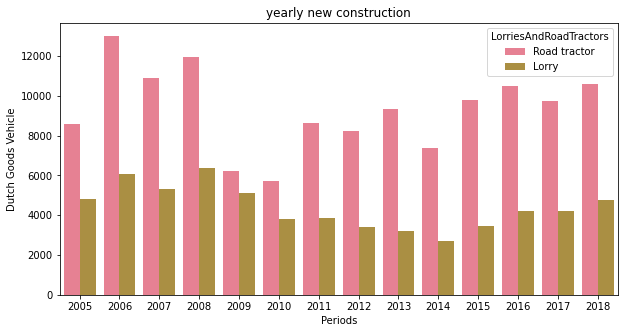

In [90]:
fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.barplot(x="Periods", y="DutchGoodsVehiclesInUse_10", 
                  hue="LorriesAndRoadTractors",
                  data=df_yearly_new_construction)

ax.set_title('yearly new construction');
ax.set_ylabel('Dutch Goods Vehicle')
plt.savefig('./image/new_registration_v_gdp.png', bbox_inches = 'tight')

In [91]:
df_yearly_new_construction = df_yearly_new_construction[['LorriesAndRoadTractors','YearsOfConstruction','yearly_new_construction']]

In [92]:
# inlude yearly new add in the df, to determine the % remain in use
df_years_in_service = pd.merge(df_years_in_service, df_yearly_new_construction,
         on = ['LorriesAndRoadTractors','YearsOfConstruction']) 

# determine the percentage of vehicle reamain in use after the corresponding number of years
df_years_in_service['DutchGoodsVehiclesInUse_%'] = 100*df_years_in_service['DutchGoodsVehiclesInUse_10']/df_years_in_service['yearly_new_construction']

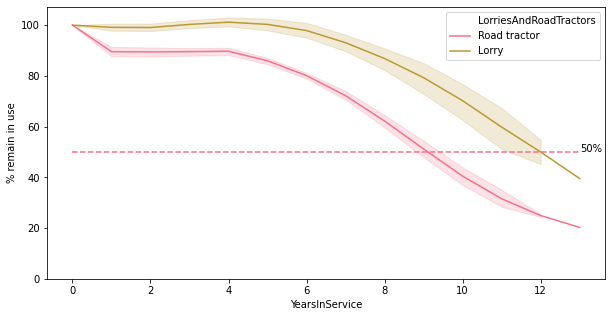

In [93]:
fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.lineplot(x="YearsInService", y="DutchGoodsVehiclesInUse_%", 
                  hue="LorriesAndRoadTractors",
                  data=df_years_in_service)

ax.set_ylabel('% remain in use')
ax.set_ylim(bottom = 0.0)
ax.hlines(50, 0, 13, linestyle = 'dashed')
ax.annotate('50%', (13,50))

fig.savefig('./image/years_in_service.png', bbox_inches = 'tight')

# link between kilometer and GDP


In [94]:
import numpy as np

In [95]:
df_yearly =  df.groupby(['Periods']).sum()
df_yearly.reset_index(inplace=True)

In [96]:
# import world bank data, and wrangle the data set
df_gdp = pd.read_csv('./data/API_NLD_DS2_en_csv_v2_1224624.csv', skiprows=4, delimiter=',')

df_gdp = df_gdp[df_gdp['Indicator Name'] == 'GDP (current US$)']
df_gdp = df_gdp.transpose()

df_gdp = df_gdp[df_gdp.applymap(np.isreal)]
df_gdp.dropna(inplace=True)
df_gdp.reset_index(inplace=True)

df_gdp.columns = ['Periods','GDP (current US$)']

df_gdp['Periods'] = df_gdp['Periods'].astype('int');
df_gdp['GDP (current US$)']= df_gdp['GDP (current US$)'].astype('float');

In [97]:
# select a subset for the period 2005 -2018
df_gdp = df_gdp.loc[(df_gdp['Periods']>=2005) & (df_gdp['Periods']<=2018) ]

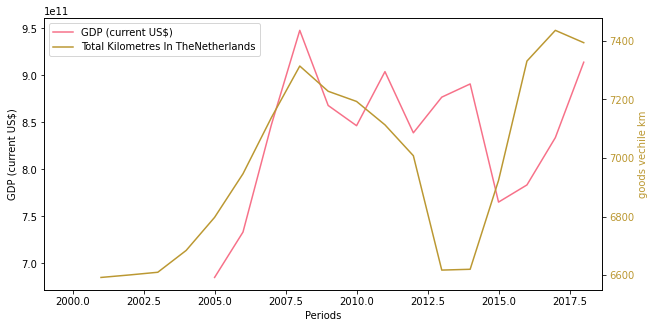

In [98]:
ax = df_gdp.plot(x = 'Periods', y = 'GDP (current US$)', figsize = (10, 5))
ax.set_ylabel('GDP (current US$)')
ax.set_xlim(left = 1999)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = sns.color_palette()[1]
ax2.set_ylabel('goods vechile km', color = color) 
ax2.tick_params(axis='y', labelcolor = color)

ax2.plot(df_yearly.Periods.astype('int').values, 
         df_yearly.KilometresByDutchVehicles_2 + df_yearly.KilometresByForeignVehicles_3, 
         color = color, label = 'Total Kilometres In TheNetherlands')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig('./image/vehicle_km_gdp.png', bbox_inches = 'tight')

## how did economy influence investment on new equipment

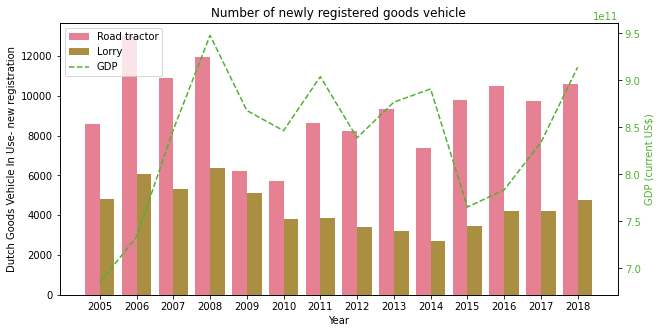

In [60]:
df_yearly_new_construction['YearsOfConstruction'] = df_yearly_new_construction['YearsOfConstruction'].astype('int')
fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.barplot(x="YearsOfConstruction", y="yearly_new_construction", 
                  hue="LorriesAndRoadTractors",
                  data=df_yearly_new_construction)

ax.set_title('Number of newly registered goods vehicle');
ax.set_ylabel('Dutch Goods Vehicle In Use- new registration')
ax.set_xlabel('Year')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = sns.color_palette()[2]
ax2.plot(ax.get_xticks(), df_gdp['GDP (current US$)'], color = color, label = 'GDP', linestyle = '--')

ax2.set_ylabel('GDP (current US$)', color = color)
ax2.tick_params(axis='y', labelcolor = color)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig('./image/new_registration_v_gdp.png', bbox_inches = 'tight')